In [27]:
#importing the libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv1D,BatchNormalization,MaxPool1D,Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-rc0


In [2]:
#get the data
data=pd.read_csv('C:\\Users\\endri.mosko\\Desktop\\Project in Jupyter notebook\\Customer Churn-Project\\data\\train.csv')

In [3]:
#read the data
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
#we are dropping the target and non-numeric features from the dataset
X=data.drop(labels=['ID','TARGET'],axis=1)

In [5]:
#giving y the value of the column "TARGET"
y=data['TARGET']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)

Feature Selections
In order to increase the accuracy of the model, we need to delete(not include during the training) all the features which do not contribute for the TARGET, features with 0 variance such as constants or quasi constants
There are different techniques to do feature selection, with that said, we do not pretend that ours is the most effective one.


In [7]:
#we will start by using a threshold variance, we will select only the features which have variance above than 1%
filter=VarianceThreshold(0.01)
X_train=filter.fit_transform(X_train)
X_test=filter.transform(X_test)

In [8]:
X_train.shape,X_test.shape

((53214, 272), (22806, 272))

In [9]:
#in order to delete the duplicate features, we will transform the columns to rows and return the array to pandas dataframe 
X_train_T=pd.DataFrame(X_train.T)
X_test_T=pd.DataFrame(X_test.T)

In [10]:
#identify the duplicates with True and False
duplicates=X_train_T.duplicated()

In [11]:
duplicates.head(10)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

In [12]:
#we have to filter the features which are not dups, in order to make the selection easier,  we will do an inversion(true will be false and false will be true)
non_dup_features=[not index for index in duplicates]

In [13]:
#we have to keep only 'True's from the non_dup_features array
X_train=X_train_T[non_dup_features].T

In [14]:
X_test=X_test_T[non_dup_features].T

In [15]:
#in order to bring the features to the same scale we use StandardScaler also when we apply StandardScaler, we convert the data from DataFrame to Numpy array
#only now we can reshape the data from 2-D in 3-D( for CNN model data needs to be 3-D)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
#checking the shape
X_train.shape,X_test.shape

((53214, 255), (22806, 255))

In [16]:
#reshaping the data
X_train=X_train.reshape(53214, 255,1)
X_test=X_test.reshape(22806, 255,1)

In [19]:
type(X_train),type(y_train)

(numpy.ndarray, pandas.core.series.Series)

In [20]:
#it looks like y is a serie. we need to covert it to numpy array
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [28]:
#Bulding CNN Model
epochs=30
model=Sequential()
model.add(Conv1D(32,3,activation='relu',input_shape=(255,1)))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.3))

model.add(Conv1D(64,3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Conv1D(128,3,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))


model.add(Dense(1,activation="sigmoid"))


In [29]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 253, 32)           128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 253, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 126, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 124, 64)           6208      
_________________________________________________________________
batch_normalization_2 (Batch (None, 124, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 62, 64)           

In [30]:
#compile the model
model.compile(optimizer=Adam(lr=0.00005),loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
#fit the model
model_data=model.fit(X_train,y_train,epochs=epochs,validation_data=(X_test,y_test),verbose=1)

W0122 11:09:18.135408  8584 deprecation.py:323] From C:\Users\endri.mosko\AppData\Local\Continuum\anaconda3\envs\endri\lib\site-packages\tensorflow_core\python\ops\nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 53214 samples, validate on 22806 samples
Epoch 1/30
53214/53214 [==============================] - 52s 984us/sample - loss: 0.2416 - accuracy: 0.9486 - val_loss: 0.2047 - val_accuracy: 0.9602
Epoch 2/30
53214/53214 [==============================] - 53s 990us/sample - loss: 0.1822 - accuracy: 0.9591 - val_loss: 0.1841 - val_accuracy: 0.9601
Epoch 3/30
53214/53214 [==============================] - 53s 1ms/sample - loss: 0.1713 - accuracy: 0.9601 - val_loss: 0.1718 - val_accuracy: 0.9605
Epoch 4/30
53214/53214 [==============================] - 55s 1ms/sample - loss: 0.1674 - accuracy: 0.9602 - val_loss: 0.1888 - val_accuracy: 0.9604
Epoch 5/30
53214/53214 [==============================] - 59s 1ms/sample - loss: 0.1644 - accuracy: 0.9603 - val_loss: 0.1698 - val_accuracy: 0.9604
Epoch 6/30
53214/53214 [==============================] - 57s 1ms/sample - loss: 0.1643 - accuracy: 0.9603 - val_loss: 0.1671 - val_accuracy: 0.9604
Epoch 7/30
53214/53214 [============================

In [32]:
#function which plot the data from model_data
def learningCurve(model_data, epoch):
    # Plot training & validation accuracy values
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, model_data.history['accuracy'])
    plt.plot(epoch_range, model_data.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(epoch_range, model_data.history['loss'])
    plt.plot(epoch_range, model_data.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

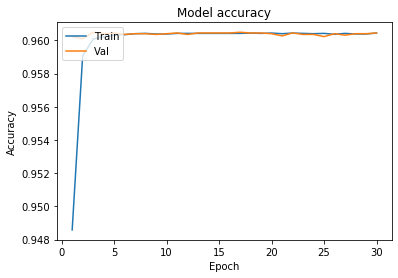

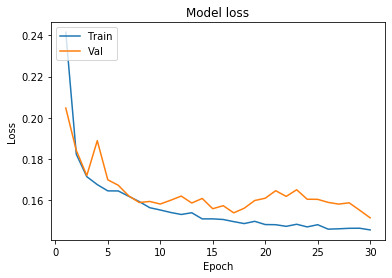

In [33]:
learningCurve(model_data, epochs)